In [1]:
import os
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [18]:
skim_file = os.getenv('DATAWORK')+'/fred/SKIM_OS_0.8m_wd=90_t=0.01.nc'

In [3]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.start_workers(4)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [4]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [ ]:
client

---

In [19]:
ds = xr.open_dataset(skim_file, chunks={'time': 1, 'x':512, 'y':512})

In [20]:
print(ds)

<xarray.Dataset>
Dimensions:  (time: 11, x: 8192, y: 8192)
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 ...
  * x        (x) float64 -3.277e+03 -3.276e+03 -3.275e+03 -3.274e+03 ...
  * y        (y) float64 -3.277e+03 -3.276e+03 -3.275e+03 -3.274e+03 ...
Data variables:
    z1       (time, x, y) float64 dask.array<shape=(11, 8192, 8192), chunksize=(1, 512, 512)>
Attributes:
    size:     [6553.6 6553.6]
    dr:       [0.8 0.8]
    current:  [0. 0.]
    seed:     312167


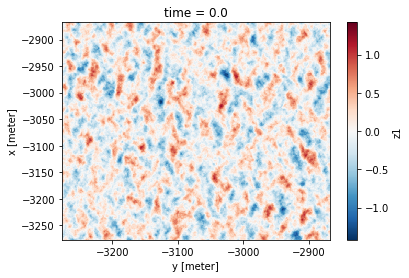

In [21]:
ds.z1.isel(time=0, x=slice(512),y=slice(512)).plot()

In [13]:
#ds.z1.std(dim='x').to_netcdf(os.getenv('DATAWORK')+'/fred/std_x.nc', mode='w')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


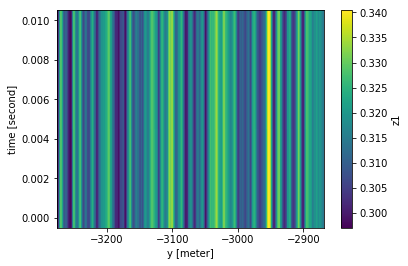

In [22]:
ds.z1.isel(y=slice(512)).std(dim='x').plot()

---

## with delayed

In [55]:
from dask import delayed, compute

def func(x):
    return np.mean(x**2)

In [79]:
z1_d = ds.z1.data.to_delayed()
#print(z1_d)
print(z1_d.shape)

values = [delayed(func)(z) for z in z1_d.flatten()]
print(len(values))

(11, 16, 16)
2816


In [74]:
result = compute(*values, get=client.get)

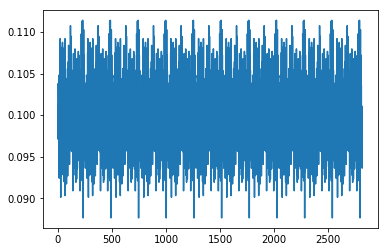

In [76]:
plt.plot(result)

In [90]:
print(np.mean(result))

0.09973921417465036


---

## with apply_ufunc

not elegant but could work

In [85]:
def func(x):
    return np.mean(x**2)*np.ones(x.shape)

z1_processed = xr.apply_ufunc(func, ds.z1,
                              dask='parallelized',
                              output_dtypes=[np.float64])

In [86]:
print(z1_processed)

<xarray.DataArray 'z1' (time: 11, x: 8192, y: 8192)>
dask.array<shape=(11, 8192, 8192), dtype=float64, chunksize=(1, 512, 512)>
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 ...
  * x        (x) float64 -3.277e+03 -3.276e+03 -3.275e+03 -3.274e+03 ...
  * y        (y) float64 -3.277e+03 -3.276e+03 -3.275e+03 -3.274e+03 ...


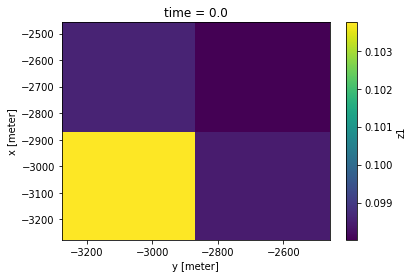

In [87]:
z1_processed.isel(time=0,x=slice(1024),y=slice(1024)).plot()

In [89]:
print(z1_processed.mean().values)

0.09973921417465036


---

In [91]:
cluster.scheduler.close()

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>

In [ ]:
client.restart()